In [1]:
import pickle
from IPython.display import display, clear_output
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
import logging
from itertools import product as iterproduct, groupby, chain
import mltools
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/context_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})
logger = logging.getLogger("log")
logger.setLevel(logging.INFO)

In [2]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle",
#     "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/ibislambda.model.pickle"
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [3]:
NMER = 6

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [6]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [7]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [8]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

CGCAGG CGCAGG


## Make Data

In [9]:
CONTEXT = (-10, 20)

In [10]:
all_kmers = mk_kmer_dict(NMER)
kmer_means = {kmer : float(HMM_PARAMS[HMM_PARAMS["kmer"] == kmer]["level_mean"]) for kmer in all_kmers}

In [11]:
template_events = [ev for ev in true_events if not np.isnan(ev["template.mean"])]
template_events = [ev for ev in template_events if 
               ev["ref_position"] > abs(CONTEXT[0]) and ev["ref_position"] < len(ref)-CONTEXT[1]-1]
template_events = np.array(template_events)

### Stratify

In [12]:
def stratify_events(events):
    """for each genomic position, only return the median event"""
    group_by = lambda x: x["ref_position"]
    sort_by = lambda x: x["template.mean"]
    events = sorted(events, key=group_by)
    events_strat = []
    for pos, group in groupby(events, key=group_by):
        group = list(group)
        group = sorted(group, key=sort_by)
        events_strat.append(group[int(len(group)/2)])
    return events_strat

In [13]:
events_strat = stratify_events(template_events)
len(events_strat), len(template_events), len(events_strat)/len(template_events)

(177924, 216348, 0.8223972488768095)

### Analyse

In [14]:
def dwelltime(ev):
    return ev["template.length"] 

def mean_diff(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

def ev_stdv(ev):
    return ev["template.stdv"]

In [15]:
def analyse_feat(target_function, plot=False):
    values = [target_function(ev) for ev in template_events]
    if plot:
        sns.distplot(values, label=str(target_function))
        legend()
    return np.percentile(values, 1), np.percentile(values, 99)
    
    

In [16]:
mean([abs(mean_diff(ev)) for ev in template_events])

0.75165734272637852

In [17]:
quantile_diff = analyse_feat(mean_diff)
quantile_diff

(-2.8495201330184319, 2.8556196116705381)

In [18]:
quantile_dwell = analyse_feat(dwelltime)
quantile_dwell

(0.0029880478087649402, 0.12284196547144755)

In [19]:
quantile_stdv = analyse_feat(ev_stdv)
quantile_stdv

(0.40073177992794412, 2.6375458797784583)

### Filter
remove outliers

In [20]:
def filter_event_ids(event_ids, all_events):
    fevent_ids = event_ids[:]
    fevent_ids = [evid for evid in  fevent_ids
                       if quantile_diff[0] <= mean_diff(all_events[evid]) <= quantile_diff[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if quantile_dwell[0] <= dwelltime(all_events[evid]) <= quantile_dwell[1]]
    fevent_ids = [evid for evid in fevent_ids 
                       if ev_stdv(all_events[evid]) <= quantile_stdv[1]]
    logger.info("events removed: {0}".format(abs(len(fevent_ids) - len(event_ids))))
    return fevent_ids


### prepare

In [21]:
def make_target(ev): 
    return ev["template.mean"] - kmer_means[ev["kmer"]]

In [22]:
def make_features(event):
    feat = []
    # 2 nt before and 2 after the 6mer
    feat.extend(mltools.seq2binvec([nt for i, nt in enumerate(_get_context(event, -2, 9)) if i in [0,1,8,9] ]))
    return feat

In [23]:
def make_data(events):     
    features = np.array([make_features(ev) for ev in events])
    target = np.array([make_target(ev) for ev in events])
    return features, target

In [24]:
features, target = make_data(events_strat)

In [25]:
k = 3

In [26]:
features[k]

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

In [27]:
[nt for i, nt in enumerate(_get_context(template_events[k], -2, 9)) if i in [0,1,8,9]]

['G', 'C', 'A', 'A']

In [28]:
target[k]

0.076891019832658003

# Target reference plots

In [29]:
np.mean([abs(x) for x in target])

0.71082873662821955

In [30]:
np.mean([abs(x)**2 for x in target])

0.9907398047580569

(-5, 5)

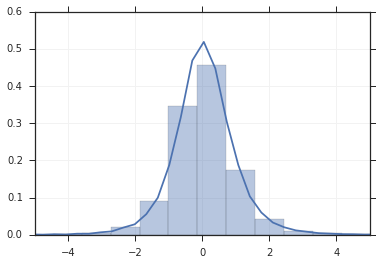

In [31]:
fig, ax = subplots()
sns.distplot(target, ax=ax)
ax.set_xlim(-5,5)

## Machine Learning

In [36]:
from sklearn import svm
from sklearn import neural_network
from sklearn.cross_validation import KFold
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics as skmetrics
from scipy import stats

In [45]:
reg = svm.LinearSVR()
# reg = svm.SVR()
kf = KFold(len(features), n_folds=3)

In [46]:
metrics = {
    "pearson": lambda x,y: stats.pearsonr(x,y)[0],
    "mae": skmetrics.mean_absolute_error,
    "mse": skmetrics.mean_squared_error
}
metrics_result = {m: [] for m in metrics}
for test, train in kf: 
    train = filter_event_ids(train, template_events)
    f_train, f_test = features[train], features[test]
    t_train, t_test = target[train], target[test]
    reg.fit(f_train, t_train)
    t_predicted= reg.predict(f_test)
    for m, f in metrics.items(): 
        metrics_result[m].append(f(t_test, t_predicted))

{m: mean(v) for (m, v) in metrics_result.items()}

INFO:log:events removed: 2770
INFO:log:events removed: 2135
INFO:log:events removed: 2347


{'mae': 0.68487221717483715,
 'mse': 0.94264479539029067,
 'pearson': 0.21943643664801479}

Referenz: alle Events, mit Outlier-Filtering im Training-Datensatz. 3-fold xval. 
```python
{'mae': 0.81686984540667729,
 'mse': 1.2425569735909825,
 'pearson': 0.49895286267417238}
```

In [47]:
reg.fit(features, target)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [40]:
import joblib

In [41]:
joblib.dump(reg, '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle', protocol=2)

['/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_01.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_02.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_03.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_04.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_05.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_06.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_prediction/model-test.pickle_07.npy',
 '/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/context_p